<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400101837
Name = 'Ali'
Last_Name = 'Kouchakzade'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

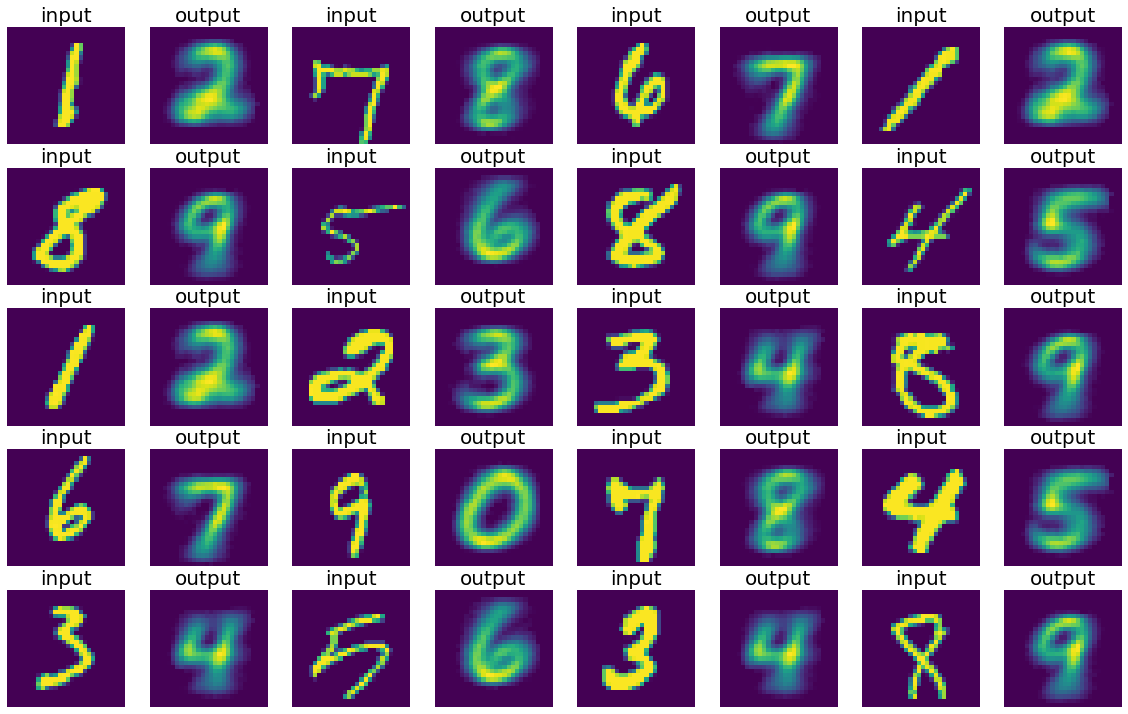

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

In [2]:
"""
AUTHOR:         Ahmad Salimi (https://github.com/ahmadsalimi)
"""


from typing import Tuple

from sklearn.datasets import fetch_openml
import numpy as np
import os
import torch
from tqdm import tqdm


def get_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ Downloads the MNIST data and processes the data for autoencoder problem.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple of input images,
            output images (input + 1), and the label of input images
    """
    X, y = fetch_openml('mnist_784', return_X_y=True, cache=True)
    X, y = X.values, y.values
    X = X.reshape(-1, 28, 28).astype('float32') / 255.0
    y = y.astype(int)

    Y = np.zeros_like(X)
    ind = y.argsort()
    X, y = X[ind], y[ind]

    c = 0
    for i in range(10):
        s = (y == i).sum()
        ss = (y == (i + 1) % 10).sum()
        if s <= ss:
            Y[c:c+s] = X[c+s:c+2*s]
        elif i < 9:
            Y[c:c+ss] = X[c+s:c+s+ss]
            Y[c+ss:c+s] = X[c+s:c+2*s-ss]
        else:
            Y[c:c+ss] = X[:ss]
            Y[c+ss:c+s] = X[:s-ss]
        c += s

    current_state = np.random.get_state()

    np.random.seed(10)
    ind = np.random.permutation(X.shape[0])
    X, Y, y = X[ind], Y[ind], y[ind]

    np.random.set_state(current_state)

    return X, Y, y

def init_mnist_subset_directories(mnist_dataset, dataset_path, subset_size=5000):
    mnist_subset = torch.utils.data.Subset(mnist_dataset, torch.randperm(len(mnist_dataset))[:subset_size])

    os.mkdir(dataset_path)

    for idx, (x, y) in enumerate(tqdm(mnist_subset)):
        label_path = os.path.join(dataset_path, str(y))
        if not os.path.exists(label_path):
            os.mkdir(label_path)
        torch.save(x, os.path.join(label_path, 'data_'+str(idx)+'.pth'))


## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [3]:
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [4]:
#### IMPLEMENT YOUR MODEL ####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # [batch, 1, 28, 28]
        self.conv1 = nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=1),  # [batch, 8, 14, 14]
        self.conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),  # [batch, 16, 7, 7]
        self.conv3 = nn.Conv2d(16, 32, kernel_size=7)  # [batch, 32, 1, 1]

        self.convT1 = nn.ConvTranspose2d(32, 16, kernel_size=7),  # [batch, 16, 7, 7]
        self.convT2 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1, output_padding=1),  # [batch, 8, 14, 14]
        self.convT3 = nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1, output_padding=1),  # [batch, 1, 28, 28]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        x = F.relu(self.convT1(x))
        x = F.relu(self.convT2(x))
        x = F.sigmoid(self.conv3(x))

        return x

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [5]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [6]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader, criterion) -> float:
    model.train()
    epoch_loss = 0

    for data in dataloader:
        img, Y, y = data
        img = img.to(device).unsqueeze(1)
        Y = Y.to(device)

        output = model(img).squeeze()
        loss = criterion(output, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * img.shape[0]

    return epoch_loss / len(dataloader.dataset)


def eval_autoencoder(model: nn.Module, dataloader: DataLoader, criterion) -> float:
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for data in dataloader:
            img, Y, y = data
            img = img.to(device).unsqueeze(1)
            Y = Y.to(device)

            output = model(img).squeeze()
            loss = criterion(output, Y)

            epoch_loss += loss.item() * img.size(0)

    return epoch_loss / len(dataloader.dataset)


cuda


## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [14]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
ae = AutoEncoder().to(device=device)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [15]:

num_epochs = 40
best_val_loss = np.inf
best_val_epoch = 0
best_val_model_state = {}

for epoch in range(num_epochs):

    train_loss = train_autoencoder(ae, optimizer, train_dataloader,criterion)

    val_loss = eval_autoencoder(ae, val_dataloader,criterion)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
        best_val_model_state = ae.state_dict().copy()

print(f'Best model found at epoch {best_val_epoch+1}, with validation loss: {best_val_loss:.4f}')

Epoch [1/40], Train Loss: 0.0866, Val Loss: 0.0692
Epoch [2/40], Train Loss: 0.0684, Val Loss: 0.0681
Epoch [3/40], Train Loss: 0.0666, Val Loss: 0.0647
Epoch [4/40], Train Loss: 0.0620, Val Loss: 0.0605
Epoch [5/40], Train Loss: 0.0592, Val Loss: 0.0588
Epoch [6/40], Train Loss: 0.0579, Val Loss: 0.0579
Epoch [7/40], Train Loss: 0.0573, Val Loss: 0.0575
Epoch [8/40], Train Loss: 0.0568, Val Loss: 0.0571
Epoch [9/40], Train Loss: 0.0564, Val Loss: 0.0568
Epoch [10/40], Train Loss: 0.0561, Val Loss: 0.0564
Epoch [11/40], Train Loss: 0.0558, Val Loss: 0.0562
Epoch [12/40], Train Loss: 0.0556, Val Loss: 0.0560
Epoch [13/40], Train Loss: 0.0554, Val Loss: 0.0559
Epoch [14/40], Train Loss: 0.0553, Val Loss: 0.0558
Epoch [15/40], Train Loss: 0.0552, Val Loss: 0.0557
Epoch [16/40], Train Loss: 0.0551, Val Loss: 0.0556
Epoch [17/40], Train Loss: 0.0550, Val Loss: 0.0556
Epoch [18/40], Train Loss: 0.0550, Val Loss: 0.0555
Epoch [19/40], Train Loss: 0.0549, Val Loss: 0.0554
Epoch [20/40], Train 

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [16]:
best_ae = AutoEncoder().to(device=device)
best_ae.load_state_dict(best_val_model_state)

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


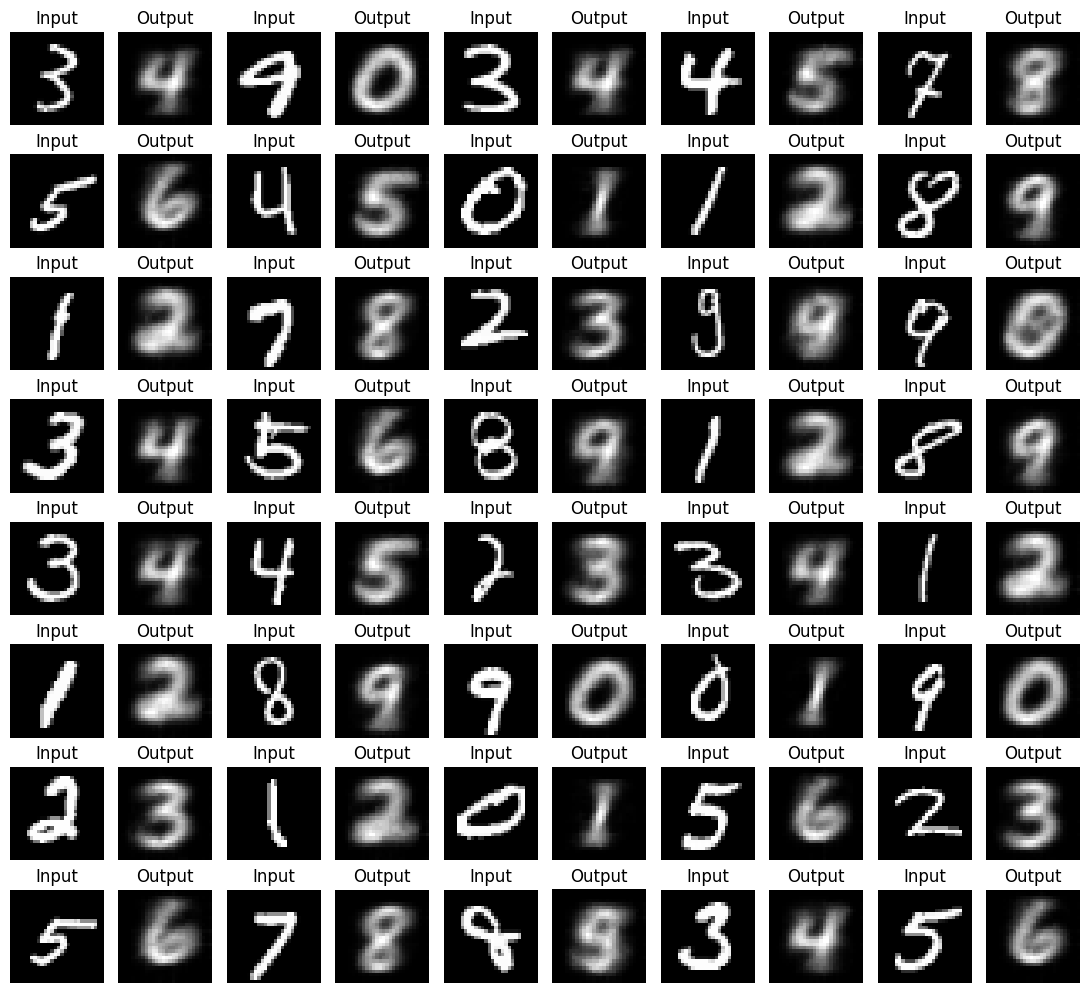

In [17]:
import matplotlib.pyplot as plt

best_ae.eval()
selected_img = torch.tensor(X_test[np.random.choice(len(X_test), 40)]).unsqueeze(1).to(device)
with torch.no_grad():
    selected_img_output = best_ae(selected_img)

plt.figure(figsize=(11,10))

for i in range(40):
    plt.subplot(8,10,2 * i + 1)
    plt.imshow(selected_img[i, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title('Input')

    plt.subplot(8,10,2*i+2)
    plt.imshow(selected_img_output[i, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title('Output')

plt.tight_layout()
plt.show()
